In [210]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
import seaborn as sns
import folium
from datetime import datetime
import pytz
from pytz import common_timezones
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)

In [430]:
df = pd.read_csv('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/data/kc_house_data_train.csv', index_col='Unnamed: 0')
print(df.shape)
df.head()

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


### Cleaning

In [660]:
df.date = pd.to_datetime(df['date'], format='%Y/%m/%d') # CLEANING: formatting date column from ICS datetime to datetime64(ns) for easier manipulation with Pandas

today = pd.to_datetime(pd.Timestamp.today(), format='%Y/%m/%d') # creates variable representing today with format matching the cleaned 'date' column formatting

df['yrs_since_sale'] = pd.to_numeric((today-df.date)/(3.154*10**16)) # FE: number representing how many years ago (from today) that the sale occurred

df['yrs_old'] = 2021-df.yr_built # FE: number representing age of property in years

df['yrs_since_renovation'] = 2021-df.yr_renovated # FE: how many years since renovation

df['yrs_since_renovation'] = np.where(df.yrs_since_renovation == 2021, # CLEANING: corrects properties that have never been renovated for engineered feature 'yrs_since_renovation'
                                      df.yrs_old, 
                                      df.yrs_since_renovation)

df['yrs_since_ren_at_sale'] = (df.yrs_since_renovation - df.yrs_since_sale) # FE: how many years since renovation at year of sale

df['sqft_yard'] = (df.sqft_lot-(df.sqft_living/df.floors)) # FE: subtracts total property livable sq. ft. divided by number of floors from lot size to estimate yard size 

df['sqft_yard'] = np.where(df.sqft_yard < 0, # sets negative yard values to 0
                                      0, 
                                      df.sqft_yard)

df['bedrooms'] = np.where(df.bedrooms == 33, # sets negative 33 bedrooms to 3 (median and likely intended entry)
                                      3, 
                                      df.bedrooms)

df['price_per_sqft_living'] = (df['price']/df['sqft_living'])

df['rural'] = np.where(df.long > -121.961527, # creates dummy variable for rural or not
                                      1, 
                                      0)

df['within_seattle_city_limits'] = np.where((df.long < -122.251569)
                                            & (df.long > -122.438230)
                                            & (df.lat < 47.734178)
                                            & (df.lat > 47.495479),
                                            1, 
                                            0)  # creates dummy variable for if property is within Seattle city limits or not

df['sale_month'] = df.date.dt.month # isolating sale month from 'date' column datetime64 object

df['sale_year'] = df.date.dt.year # isolating sale year from date' column datetime64 object

# Creating dummy variable columns for each season
df['sale_season_winter'] = np.where(((df.sale_month == 1)
                                   | (df.sale_month == 2)
                                   | (df.sale_month == 3)),
                                   1,
                                   0)

df['sale_season_spring'] = np.where(((df.sale_month == 4)
                            | (df.sale_month == 5)
                            | (df.sale_month == 6)),
                             1,
                             0)

df['sale_season_summer'] = np.where(((df.sale_month == 7)
                                   | (df.sale_month == 8)
                                   | (df.sale_month == 9)),
                                   1,
                                   0)

df['sale_season_fall'] = np.where(((df.sale_month == 10)
                                 | (df.sale_month == 11)
                                 | (df.sale_month == 12)),
                                  1,
                                  0)

df.drop(columns='id', inplace = True) # not relevant to analysis nor predictive model

In [703]:
df['sale_month'] = df.date.dt.month # isolating sale month from 'date' column datetime64 object

In [705]:
df['sale_year'] = df.date.dt.year # isolating sale year from date' column datetime64 object

In [708]:
df['sale_season_winter'] = np.where(((df.sale_month == 1)
                                   | (df.sale_month == 2)
                                   | (df.sale_month == 3)),
                                   1,
                                   0)

In [710]:
df['sale_season_spring'] = np.where(((df.sale_month == 4)
                            | (df.sale_month == 5)
                            | (df.sale_month == 6)),
                             1,
                             0)

In [711]:
df['sale_season_summer'] = np.where(((df.sale_month == 7)
                                   | (df.sale_month == 8)
                                   | (df.sale_month == 9)),
                                   1,
                                   0)

In [712]:
df['sale_season_fall'] = np.where(((df.sale_month == 10)
                                 | (df.sale_month == 11)
                                 | (df.sale_month == 12)),
                                  1,
                                  0)

### Creating Dummies

#### Note: Need to evaluate dummy_df and see which columns to drop to avoid multicoliniarity

In [444]:
# dummy dataframes for individual categories
floors_dummy_df = pd.get_dummies(df, columns=['floors'], drop_first=True)
bedrooms_dummy_df = pd.get_dummies(df, columns=['bedrooms'], drop_first=True)
bathrooms_dummy_df = pd.get_dummies(df, columns=['bathrooms'], drop_first=True)
zipcode_dummy_df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)
yrs_since_sale_dummy_df = pd.get_dummies(df, columns=['yrs_since_sale'], drop_first=True)
yrs_old_dummy_df = pd.get_dummies(df, columns=['yrs_old'], drop_first=True)
yrs_since_renovation_dummy_df = pd.get_dummies(df, columns=['yrs_since_renovation'], drop_first=True)
yrs_since_ren_at_sale_dummy_df = pd.get_dummies(df, columns=['yrs_since_ren_at_sale'], drop_first=True)

# PRIMARY DUMMY DF
dummy_df = pd.get_dummies(df, columns = [
    'floors', 
    'bedrooms', 
    'bathrooms', 
    'view', 
    'condition', 
    'grade', 
    'zipcode',
    'yrs_since_sale',
    'yrs_old',
    'yrs_since_renovation',
    'yrs_since_ren_at_sale'
], drop_first=True
                         )

dummy_df.drop(columns = [
    'bedrooms', 
    'bathrooms', 
    'floors',
    'view', 
    'condition', 
    'grade', 
    'zipcode',
    'yrs_since_sale',
    'yrs_old',
    'yrs_since_renovation',
    'yrs_since_ren_at_sale', # here and above have been turned in to dummies
    'date', # here and below are unnecessary or redundant
    'yr_built',
    'yr_renovated',
    'lat',
    'long'
], axis=1
             ) 

In [462]:
dummy_df

,date,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sqft_yard,price_per_sqft_living,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,...,yrs_since_ren_at_sale_67,yrs_since_ren_at_sale_68,yrs_since_ren_at_sale_69,yrs_since_ren_at_sale_70,yrs_since_ren_at_sale_71,yrs_since_ren_at_sale_72,yrs_since_ren_at_sale_73,yrs_since_ren_at_sale_74,yrs_since_ren_at_sale_75,yrs_since_ren_at_sale_76,yrs_since_ren_at_sale_77,yrs_since_ren_at_sale_78,yrs_since_ren_at_sale_79,yrs_since_ren_at_sale_80,yrs_since_ren_at_sale_81,yrs_since_ren_at_sale_82,yrs_since_ren_at_sale_83,yrs_since_ren_at_sale_84,yrs_since_ren_at_sale_85,yrs_since_ren_at_sale_86,yrs_since_ren_at_sale_87,yrs_since_ren_at_sale_88,yrs_since_ren_at_sale_89,yrs_since_ren_at_sale_90,yrs_since_ren_at_sale_91,yrs_since_ren_at_sale_92,yrs_since_ren_at_sale_93,yrs_since_ren_at_sale_94,yrs_since_ren_at_sale_95,yrs_since_ren_at_sale_96,yrs_since_ren_at_sale_97,yrs_since_ren_at_sale_98,yrs_since_ren_at_sale_99,yrs_since_ren_at_sale_100,yrs_since_ren_at_sale_101,yrs_since_ren_at_sale_102,yrs_since_ren_at_sale_103,yrs_since_ren_at_sale_104,yrs_since_ren_at_sale_105,yrs_since_ren_at_sale_106,yrs_since_ren_at_sale_107,yrs_since_ren_at_sale_108,yrs_since_ren_at_sale_109,yrs_since_ren_at_sale_110,yrs_since_ren_at_sale_111,yrs_since_ren_at_sale_112,yrs_since_ren_at_sale_113,yrs_since_ren_at_sale_114,yrs_since_ren_at_sale_115,yrs_since_ren_at_sale_116
0,2014-10-06,365000.0,2070,8893,0,2070,0,1986,0,47.4388,-122.162,2390,7700,7858.000000,176.328502,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,1830,1070,1977,0,47.6784,-122.285,2370,6283,3830.000000,298.275862,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,3770,0,1997,0,47.5646,-122.129,3710,9685,9008.000000,275.331565,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,4560,0,1990,0,47.6995,-122.228,4050,14226,12328.000000,326.754386,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,2550,0,2004,0,47.6647,-122.083,2250,4050,4101.000000,278.823529,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2015-03-03,750000.0,3240,9960,0,2020,1220,1958,0,47.5858,-122.112,2730,10400,6720.000000,231.481481,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17286,2014-05-20,440000.0,1300,4000,0,1300,0,1948,0,47.6687,-1

In [283]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.0
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.0
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.0
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.0
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.0


In [123]:
len(df.columns)

22

## REMEMBER, don't let perfect be the enemy of good!
- Sean suggests taking 3 columns and practicing cleaning them. 
- start with a heatmap and see which 3 feature seem to have the best indicators for price
- maybe create 2-3 engineered features
- **do not** imput data for target value 'price'!!
  - **drop** any rows missing from 'price'
- Review Viktor's Friday lecture for using folds on training data

## Initial EDA

- 17290 rows of items
- 22 columns
  - 22 columns originally
  - Former column **'Unnamed: 0'** imported as index column
  - added **years_old**
- 0 null items

- id
- date
- **price**
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- waterfront
- view
- condition
- grade
- sqft_above
- sqft_basement
- yr_built
- yr_renovated
- zipcode
- lat 
- long
- sqft_living15
- sqft_lot15

### Correlation Matrix & Heatmap

Predictors correlated with **price**:
- **sqft_living**
- **grade**
- sqft_living15
- Bathrooms
- sqft_above

Note:
- Grade and sqft_living are highly correlated with each other (.763)
  - careful with multicolinearity with these two
  - this also goes for sqft_living15 for both
  - this also goes for bathrooms for both

In [647]:
corr_matrix = df.corr()
corr_matrix

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits
price,1.000000,0.313775,0.524335,0.703540,0.086803,0.256985,0.275779,0.395485,0.036099,0.666215,0.607760,0.323312,0.056450,0.117770,-0.048958,0.302394,0.019327,0.585567,0.081423,-0.015662,-0.056450,0.111561,-0.104582,0.080252,0.557401,-0.027923,0.077283
bedrooms,0.313775,1.000000,0.524033,0.588536,0.030674,0.179908,-0.008668,0.082724,0.021376,0.366405,0.488420,0.307873,0.159936,0.014489,-0.152831,-0.003991,0.129593,0.401073,0.028038,0.006892,-0.159936,0.002530,-0.168838,0.024012,-0.206218,-0.019717,-0.181131
bathrooms,0.524335,0.524033,1.000000,0.755270,0.085470,0.497967,0.065848,0.188817,-0.122976,0.664191,0.686853,0.282700,0.507761,0.048140,-0.201527,0.023074,0.221308,0.568080,0.086499,0.019847,-0.507761,0.009646,-0.537027,0.079977,-0.085434,0.037056,-0.170215
sqft_living,0.703540,0.588536,0.755270,1.000000,0.166810,0.357169,0.109738,0.283336,-0.061530,0.762929,0.876696,0.435529,0.319397,0.051448,-0.195893,0.052646,0.234453,0.755066,0.179570,0.021845,-0.319397,0.027018,-0.343102,0.157072,-0.083806,0.044023,-0.211327
sqft_lot,0.086803,0.030674,0.085470,0.166810,1.000000,-0.002205,0.015356,0.073058,-0.013715,0.110320,0.180755,0.008065,0.054228,0.004520,-0.126590,-0.082029,0.226190,0.136959,0.701875,-0.004846,-0.054228,0.000579,-0.052844,0.999882,-0.029611,0.215263,-0.161697
floors,0.256985,0.179908,0.497967,0.357169,-0.002205,1.000000,0.025132,0.025883,-0.259230,0.458984,0.528509,-0.247481,0.483657,0.005985,-0.060560,0.048227,0.128795,0.283933,-0.008170,0.017020,-0.483657,-0.030578,-0.499076,0.003882,0.004718,0.051643,0.045696
waterfront,0.275779,-0.008668,0.065848,0.109738,0.015356,0.025132,1.000000,0.407565,0.009608,0.092234,0.077162,0.083433,-0.021981,0.094268,0.034282,-0.013331,-0.042728,0.091090,0.026895,-0.000598,0.021981,0.094391,-0.005253,0.014079,0.201687,-0.018163,-0.021550
view,0.395485,0.082724,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000,0.045060,0.249554,0.164747,0.279939,-0.049593,0.091291,0.089475,0.003820,-0.077572,0.279999,0.073185,0.002564,0.049593,0.093514,0.020493,0.069142,0.224091,0.005971,0.048725
condition,0.036099,0.021376,-0.122976,-0.061530,-0.013715,-0.259230,0.009608,0.045060,1.000000,-0.142066,-0.157466,0.166923,-0.358921,-0.060969,0.007068,-0.009927,-0.109200,-0.094307,-0.007125,0.037112,0.358921,-0.033175,0.392196,-0.015965,0.107385,-0.082266,0.032983
grade,0.666215,0.366405,0.664191,0.762929,0.110320,0.458984,0.092234,0.249554,-0.142066,1.000000,0.758247,0.165003,0.448003,0.007988,-0.184946,0.116196,0.198369,0.715745,0.116062,0.022100,-0.448003,-0.025272,-0.459082,0.104752,0.129692,-0.003712,-0.149308


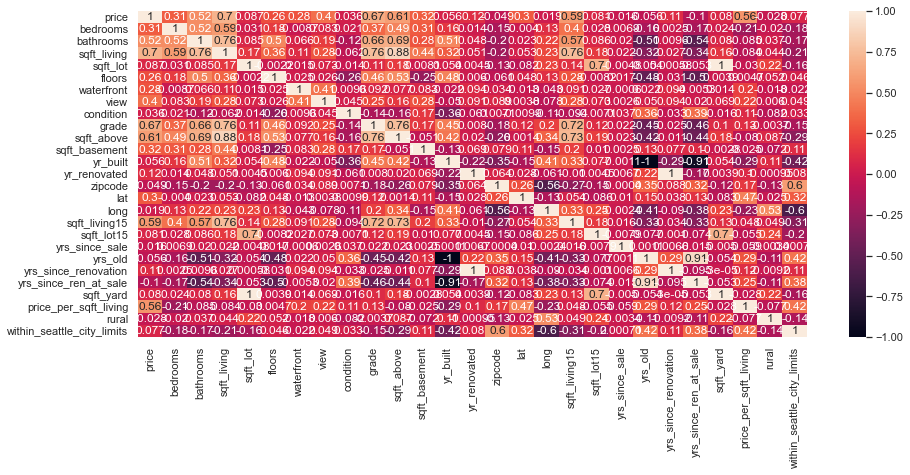

In [651]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, ax=ax);

In [658]:
df[df.yrs_since_ren_at_sale == 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits
117,2014-10-29,385195.0,1,1.00,710,6000,1.5,0,0,3,6,710,0,2015,0,98144,47.5756,-122.316,1440,4800,6,6,6,0,5526.666667,542.528169,0,1
326,2014-07-01,476000.0,4,3.00,2890,6885,1.0,0,0,3,7,1590,1300,1945,2015,98115,47.6763,-122.282,2180,6885,6,76,2015,0,3995.000000,164.705882,0,1
835,2015-03-05,335000.0,3,2.00,1210,9926,1.0,0,0,4,7,1210,0,1954,2015,98006,47.5731,-122.135,1690,9737,6,67,2015,0,8716.000000,276.859504,0,0
860,2015-01-23,459000.0,4,3.00,1900,9077,2.0,0,0,3,7,1900,0,1954,2015,98155,47.7684,-122.304,1900,12868,6,67,2015,0,8127.000000,241.578947,0,0
948,2014-10-06,825000.0,3,2.50,3400,38400,1.0,0,4,3,8,1870,1530,1955,2015,98177,47.7611,-122.372,3400,24338,6,66,2015,0,35000.000000,242.647059,0,0
2419,2014-10-28,285000.0,4,3.50,2770,10505,2.0,0,0,3,8,2770,0,1940,2015,98133,47.7412,-122.355,1760,10505,6,81,2015,0,9120.000000,102.888087,0,0
6233,2014-06-17,350000.0,3,2.00,1380,3600,3.0,0,0,3,8,1380,0,2015,0,98122,47.6074,-122.305,1480,3600,6,6,6,0,3140.000000,253.623188,0,1
6800,2014-06-24,455000.0,2,1.50,1200,1259,2.0,0,0,3,8,1000,200,2015,0,98144,47.6001,-122.298,1320,1852,6,6,6,0,659.000000,379.166667,0,1
7048,2014-07-31,230000.0,3,1.50,1040,1264,2.0,0,0,3,9,900,140,2015,0,98144,47.5951,-122.301,1350,3000,6,6,6,0,744.000000,221.153846,0,1
7278,2015-02-03,1150000.0,5,4.25,4010,8252,2.0,0,0,3,10,4010,0,2015,0,98075,47.5974,-122.013,3370,8252,6,6,6,0,6247.000000,286.783042,0,0


### Cleaned
- **date**
  - date coming in originally in ICS Datetime format
    - YYYYMMDDTHHMMSS
    - year month day time hour minute seconds
    - can drop T, hour, minute and seconds. Doesn't seem to have any info.
    - the rest can be interpreted as type(DateTime)
- **sqft_yard** 
  - four had negative values
  - set value to 0 for those using np.where statement

### Further Exploration

#### id 
  - Unique ID for each home sold
  - This will not contribute to analysis or prediction of property values.
  - **Dropped**

#### date 
- Date of the home sale


#### price
- Price of each home sold.
- **TARGET**
- float dtype
- price mean: 540739.5
- price standard deviation: 373319.0
- price median: 450000.0
- price IQR: 321000.0 — 645000.0
- no null values to drop

#### bedrooms
- 1 listing with **33 BEDROOMS**. Super outlier. Changed to 3 (median, and likely intended data entry). 
- Scaling down likely best practice over dropping, unless data is wrong.
- 1620 sq_ft living with 6000 sqft_lot, and $\$$640,000 sale price
- 12 values with 0 listed. 

In [237]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [233]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
8597,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,6,74,74


In [235]:
df.bedrooms.median()

3.0

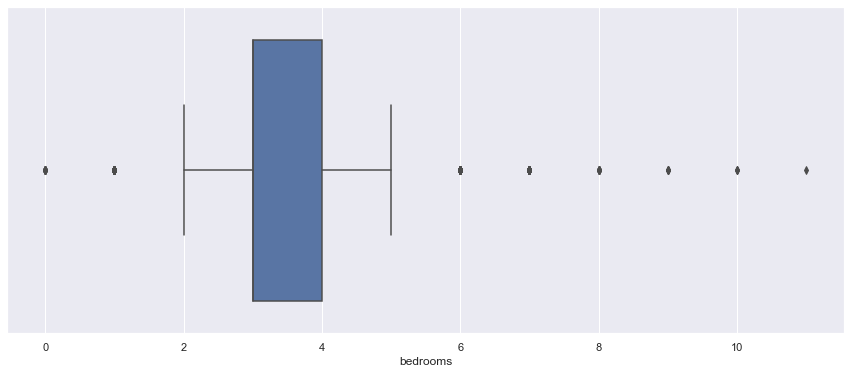

In [650]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df.bedrooms, ax=ax);

In [272]:
df.groupby('bedrooms')['price'].median()

bedrooms
0     304000.0
1     310000.0
2     370000.0
3     411100.0
4     550000.0
5     612995.0
6     655000.0
7     760000.0
8     854000.0
9     700000.0
10    660000.0
11    520000.0
Name: price, dtype: float64

In [276]:
df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

managing 33 bedroom listing **DONE**:
- plugging in the lat/long reveals a street with several nice, but modest homes. 
- Most likely the property has somewhere closer to the median 3 bedrooms, which would make sense if 33 was entered erroneously in place of 3.
- There is one interesting looking property tucked away on street view that could be a sort of residential complex, but it doesn’t look that big from what I can take away.
- Either way, when building a model, scaling down outliers to within a boxplot max would likely be necessary. Alternatively, impute to median. Could manage with both methods if using another factor for conditions, e.g. ‘sqft_living’

managing listed with seemingly high bedroom counts:
- value counts for each # of bedrooms begin to get significantly lower past 5
- should cap bedrooms for listed over 5, 6, 7, or 8.
  - argument in favor of over 5 or 6:
    - fractional dropoff for number of listings in this range
  - argument in favor of over 8:
    - prices begin to get lower after this value. 

managing listed with 0 bedroom counts:
- drop **WARNING** can we drop values for holdout data?
- alternatively impute 1 or median depending on sq_ft range
  - use confidence interval to determine ranges for what is probable for each number of bedrooms possible

In [238]:
df[df.bedrooms == 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
3680,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745,6,108,108
11181,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400,6,13,13
17114,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914,6,63,63


- first is small residence. likely data entry error but unsure what to impute. 
  - has 3 bathrooms which should indicate more bedrooms.
  - ALMOST CERTAINLY has had a renovation since 1913 but lists none.
- second appears to be 
groupby # bedrooms and median price, mean price

In [239]:
df[df.bedrooms == 11]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
2356,1773100755,2014-08-21,520000.0,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.556,-122.363,1420,4960,6,103,22


In [ ]:
df['bedrooms'] = np.where(df.bedrooms == 10, # sets negative 33 bedrooms to 3 (median and likely intended entry)
                                      1, 
                                      df.bedrooms)

In [277]:
df[df.bedrooms == 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard
483,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,5,31,31,26,6819.000000
1120,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,6,31,31,25,3888.571429
2430,2014-10-29,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341,6,18,18,12,213060.000000
3032,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,6,25,25,19,4065.000000
3609,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751,6,36,36,30,7174.000000
5424,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,6,15,15,9,0.000000
6409,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650,6,22,22,16,0.000000
9286,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,6,31,31,25,25603.000000
10067,2014-09-26,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,6,58,58,52,20585.000000
10074,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685,6,18,18,12,4764.000000


#### bathrooms
- Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- can be considered categorical as they are countable, not constant
- form dummy variables

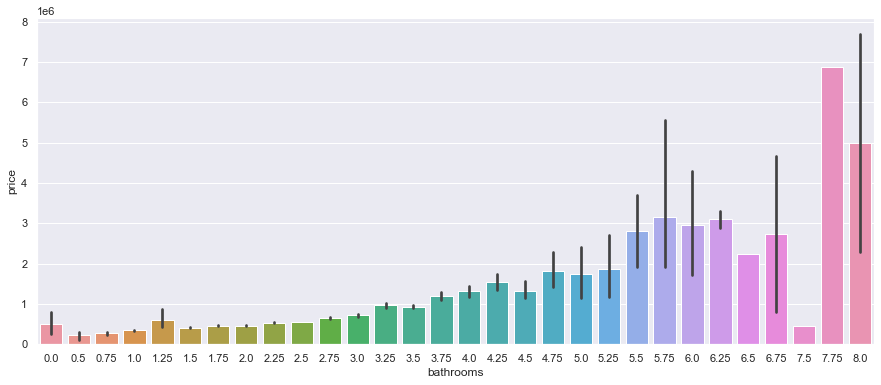

In [385]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=df.bathrooms, y=df.price, ax=ax);

In [583]:
df[df.bathrooms == 7.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
3425,2014-08-11,450000.0,9,7.5,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866,6,25,25,19,4479.0,111.111111


In [393]:
baths = df[df.bathrooms < 5.75]

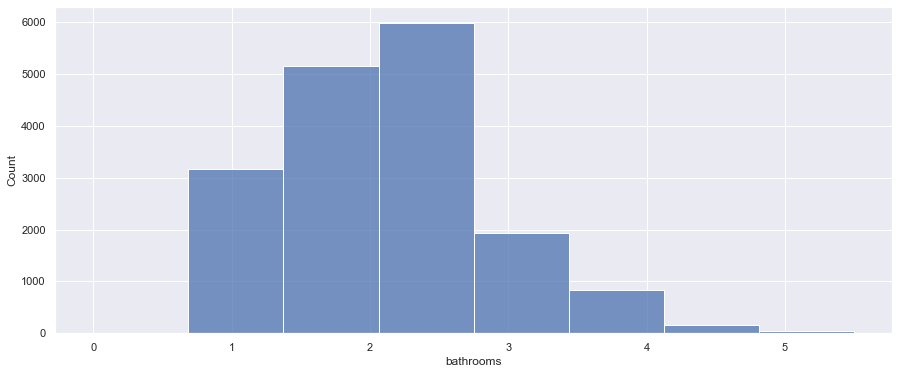

In [403]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(baths.bathrooms, ax=ax, bins=8);

- Creating dummy variable df:

In [425]:
br_dummy_df = pd.get_dummies(df, columns=['bathrooms'], drop_first=True)
br_dummy_df

,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0
0,2014-10-06,365000.0,4,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.000000,176.328502,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,5,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.000000,298.275862,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,4,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.000000,275.331565,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,3,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.000000,326.754386,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,3,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.000000,278.823529,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2015-03-03,750000.0,5,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,6,63,63,57,6720.000000,231.481481,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17286,2014-05-20,440000.0,2,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,6,73,73,67,3350.000000,338.461538,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17287,2014-05-14,310000.0,3,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,6,68,68,62,8826.000000,295.238095,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17288,2014-12-04,427500.0,3,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,6,50,50,44,41919.333333,225.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [410]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=baths, x='bathrooms', y='price', hue='waterfront',
               split=True, inner="quart", linewidth=1,
               ax=ax)
sns.despine(left=True)

Error in callback <function flush_figures at 0x7fbcf3ca13a0> (for post_execute):


KeyboardInterrupt: 

#### sqft_living
- Square footage of the apartments interior living space
- EDA:
  - excellent indicator of price, with variance increasing as sqft_living goes up.
  - furthest points out are not outliers

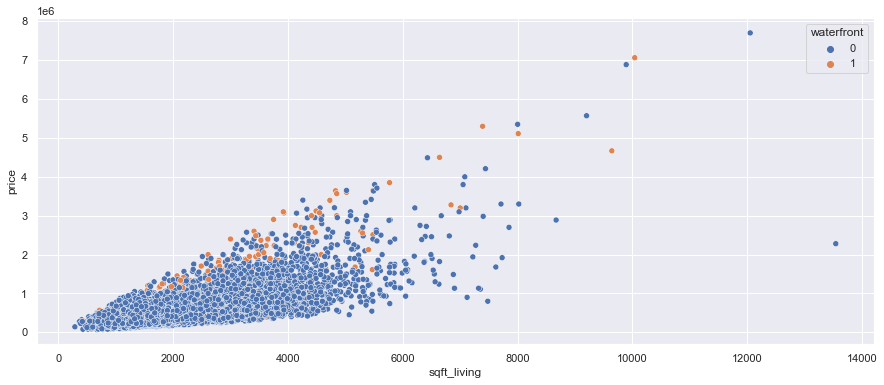

In [411]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_living, y=df.price, hue='waterfront', ax=ax);

In [464]:
df[df['sqft_living'] > 12000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
3275,2014-05-05,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,6,22,22,16,303238.666667,168.389956
10366,2014-10-13,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,6,111,34,28,22780.000000,639.004149


#### sqft_lot
- Square footage of the land space (total property)
- I'm not entirely sure if I'm interpreting the log-10 groupby histogram below well, worth asking Sean for help understanding. 
- used this to create sqft_yard:
  - sqft_lot-(sqft_living/floors)

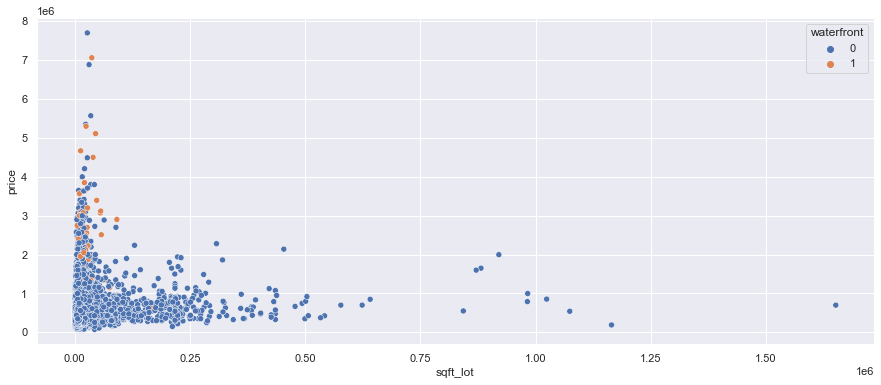

In [465]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_lot, y=df.price, hue='waterfront', ax=ax);

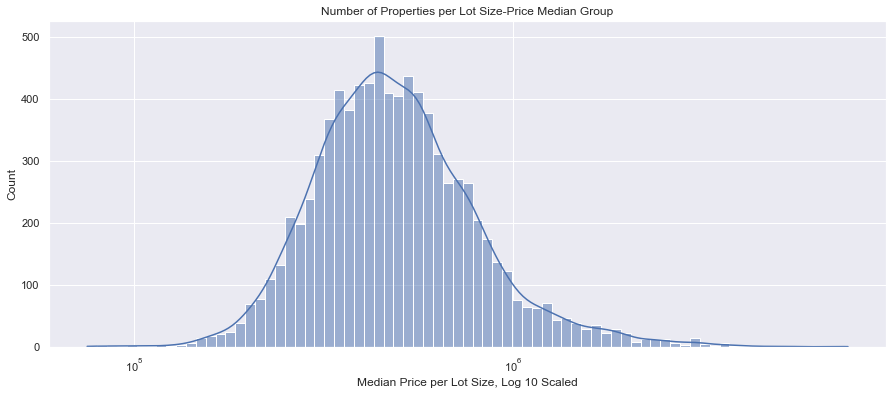

In [504]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Lot Size, Log 10 Scaled')
ax.set_title('Number of Properties per Lot Size-Price Median Group')
sns.histplot(data=df, x=df.groupby('sqft_lot')['price'].median(), kde=True, log_scale=10, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot'], kde=True, log_scale=10, ax=ax);

#### floors
- Number of floors
- may be useful to drop AFTER use in creating other features, such as sqft_lawn

In [253]:
df[df.floors == 0] # checking for errors in data entry, no mistakes
df[df.floors > 3] # no severe outliers, though I wonder what .5 floors looks like

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale
1120,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,6,31,31,25
3757,2014-10-20,3300000.0,8,4.00,7710,11750,3.5,0,0,5,12,6090,1620,1904,0,98112,47.6263,-122.314,4210,8325,6,117,117,111
4696,2014-06-25,563500.0,3,2.50,1400,1312,3.5,0,0,3,8,1400,0,2007,0,98103,47.6534,-122.355,1350,1312,6,14,14,8
4911,2015-04-02,525000.0,3,3.00,1730,1074,3.5,0,0,3,8,1730,0,2006,0,98107,47.6692,-122.392,1370,1185,5,15,15,10
15337,2014-09-18,525000.0,2,2.75,1310,1268,3.5,0,0,3,8,1310,0,2007,0,98103,47.6534,-122.355,1350,1288,6,14,14,8
15963,2015-04-16,479000.0,2,2.50,1730,1037,3.5,0,0,3,8,1730,0,2008,0,98118,47.5594,-122.285,1280,1026,5,13,13,8
16446,2015-01-30,544000.0,3,2.50,1760,1755,3.5,0,0,3,8,1760,0,1998,0,98105,47.6688,-122.279,1700,1721,6,23,23,17


#### waterfront
- A dummy variable for whether the apartment was overlooking the waterfront or not
- dang this adds an average of $\$$1,156,981 to property value.

In [262]:
df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

In [288]:
df[df.waterfront == 1].price.mean() - df[df.waterfront == 0].price.mean()

1156981.0605734913

In [263]:
df[df.waterfront == 1].price.mean()

1688486.1739130435

In [264]:
df[df.waterfront == 1].price.median()

1405000.0

In [265]:
df[df.waterfront == 0].price.mean()

531505.1133395522

In [267]:
df[df.waterfront == 0].price.median()

450000.0

In [268]:
df[df.waterfront == 1].price.max()

7062500.0

In [270]:
df[df.price == 7062500.0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard
6903,2014-06-11,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,6,81,20,14,32305.0


In [511]:
df[df.waterfront == 0].price

0         365000.0
1         865000.0
2        1038000.0
3        1490000.0
4         711000.0
           ...    
17285     750000.0
17286     440000.0
17287     310000.0
17288     427500.0
17289     348000.0
Name: price, Length: 17152, dtype: float64

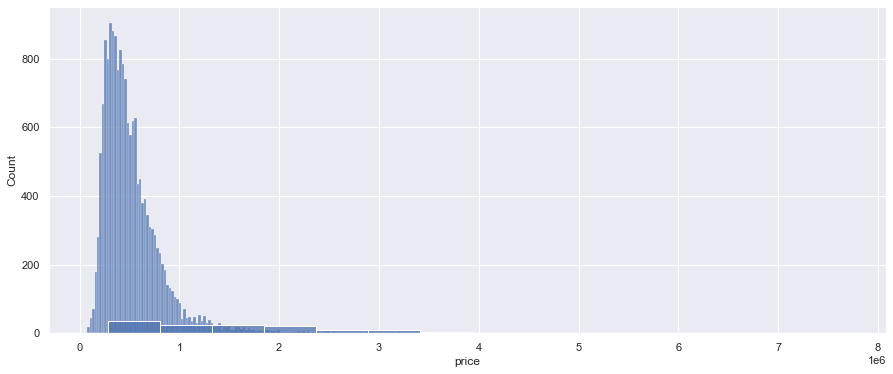

In [520]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(data=df, x=df[df.waterfront == 0].price, ax=ax)
sns.histplot(data=df, x=df[df.waterfront == 1].price, ax=ax);

<AxesSubplot:xlabel='waterfront', ylabel='price'>

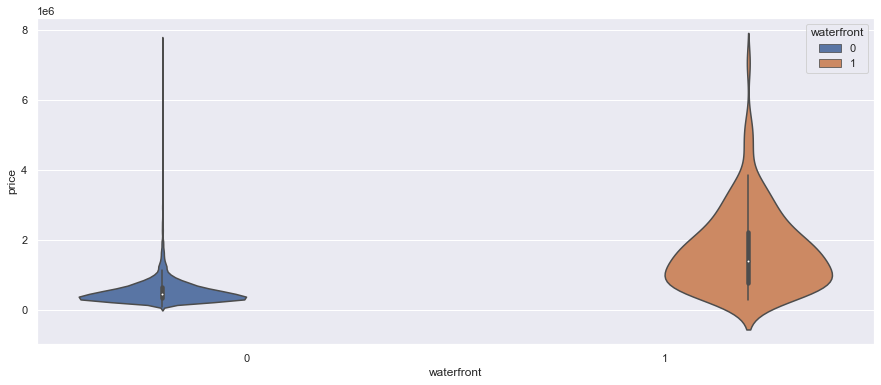

In [506]:
fig, ax = plt.subplots(figsize=(15,6))

sns.violinplot(data=df, x='waterfront', y='price', hue='waterfront');

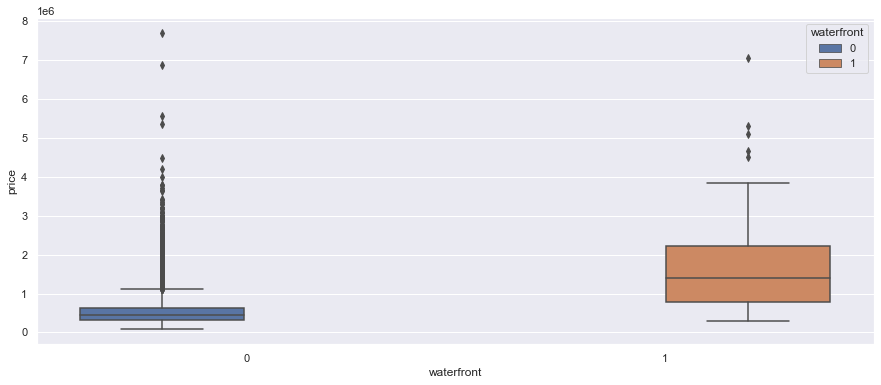

In [509]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxplot(data=df, x='waterfront', y='price', hue='waterfront');

#### view
- An index from 0 to 4 of how good the view of the property was
- **TOO MANY VALUES FOR 0 TO BE INTERESTING**
  - Additionally, higher-view rating categories seem to be dominated by 'waterfront' properties. 
  - this is despite the fact that waterfront properties make up less than 1% of the data.
- tempted to drop. seems far too subjective of a category, which suggests there will be no consistency among the ratings.
  - this could be corrected for if there are objective measures for how this is done, but without further details on the data collection methods, this is impossible to tell

In [529]:
df.view.value_counts()

0    15571
2      775
3      410
4      270
1      264
Name: view, dtype: int64

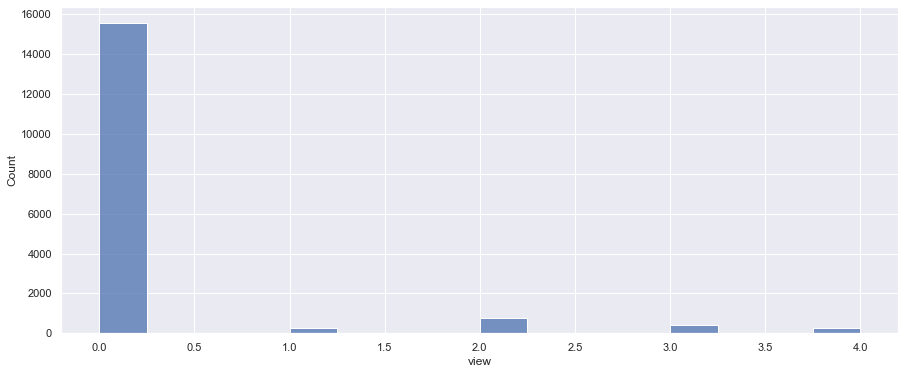

In [535]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(data=df, x=df['view'], ax=ax);

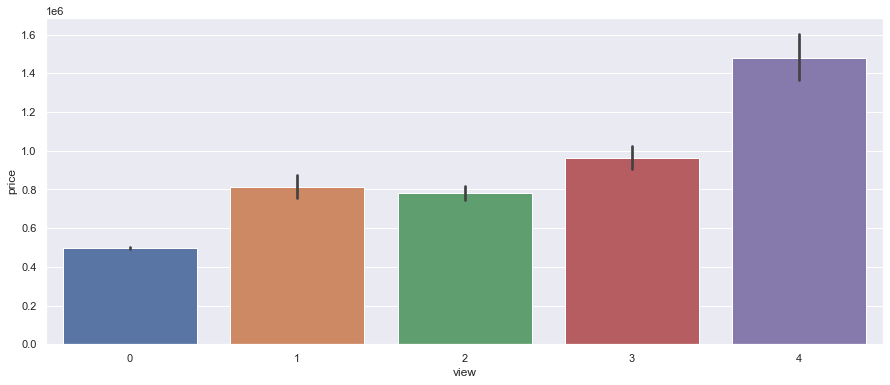

In [526]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df, x=df.view, y=df.price, ax=ax);

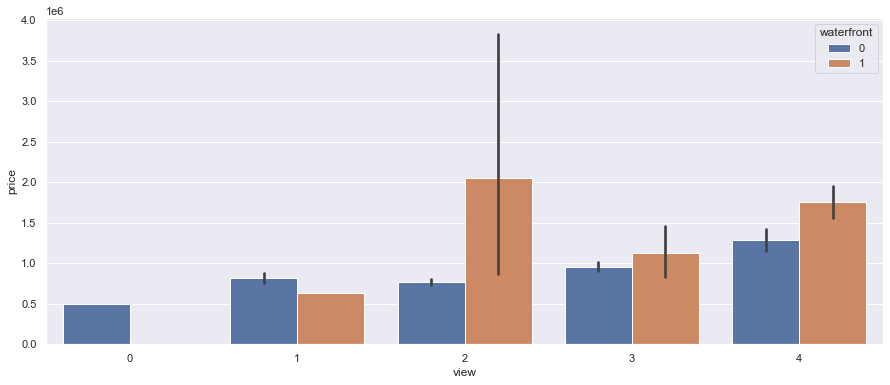

In [524]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df, x=df.view, y=df.price, hue='waterfront', ax=ax);

In [538]:
df[df.waterfront == 0].value_counts().sum()

17152

In [537]:
df[df.waterfront == 1].value_counts().sum()

138

In [543]:
df[df.waterfront == 1].value_counts().sum()/df[df.waterfront == 0].value_counts().sum()

0.008045708955223881

In [291]:
df[df.view == 0].price.mean()

496770.421231777

In [292]:
df[df.view == 1].price.mean()

813770.178030303

In [293]:
df[df.view == 2].price.mean()

779421.2193548387

In [294]:
df[df.view == 3].price.mean()

964004.756097561

In [295]:
df[df.view == 4].price.mean()

1481651.2777777778

#### condition
- An index from 1 to 5 on the condition of the apartment
- Note: could cause multiple colinearity with yrs_since_renovation_at_sale (and others)

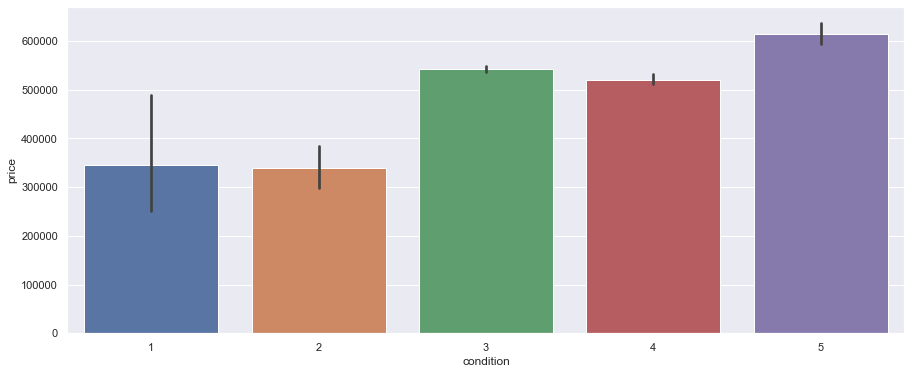

In [568]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df, x=df['condition'], y=df['price'], ax=ax);

In [559]:
df.groupby('condition')['price'].median()

condition
1    262500.0
2    280000.0
3    451000.0
4    440000.0
5    530000.0
Name: price, dtype: float64

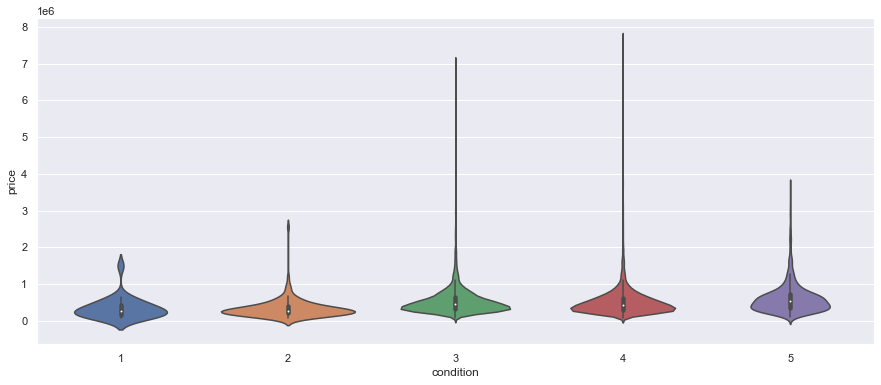

In [572]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(x=df.condition, y=df.price, ax=ax);

In [522]:
df[df.condition == 1].price.mean()

346372.9166666667

In [298]:
df[df.condition == 2].price.mean()

339570.7841726619

In [299]:
df[df.condition == 3].price.mean()

542532.6626645322

In [300]:
df[df.condition == 4].price.mean()

520915.7223206377

In [301]:
df[df.condition == 5].price.mean()

615348.0950987564

#### grade
- An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- Represents the construction quality of improvements. 
- ranges from 1 to 13
  - 1-3 Falls short of minimum building standards. Normally cabin or inferior structure.
  - 4 Generally older, low quality construction. Does not meet code.
  - 5 Low construction costs and workmanship. Small, simple design.
  - 6 Lowest grade currently meeting building code. Low quality materials and simple designs.
  - 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.
  - 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
  - 9 Better architectural design with extra interior and exterior design and quality.
  - 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
  - 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
  - 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
  - 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

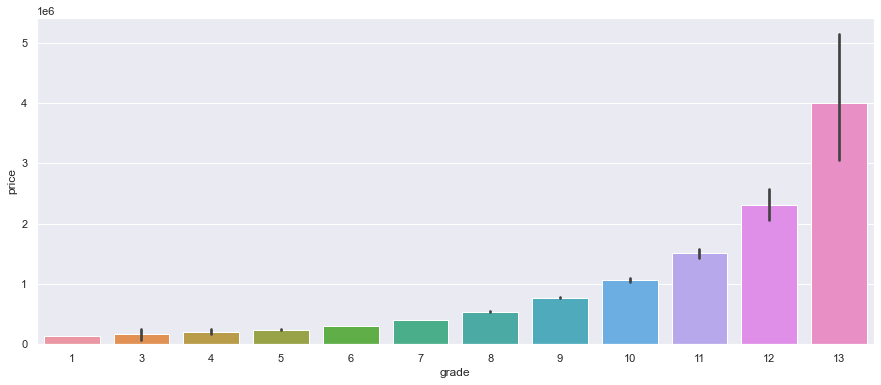

In [582]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df, x=df['grade'], y=df['price'], ax=ax);

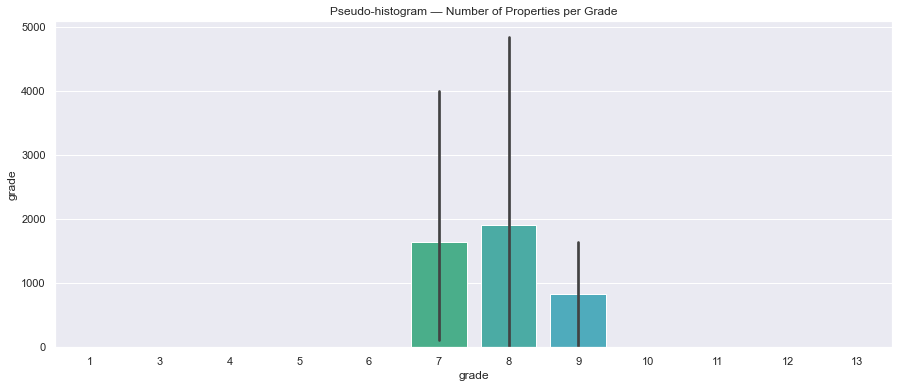

In [580]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Pseudo-histogram — Number of Properties per Grade')
ax.set_ylabel('Total Properties') #dang y label won't set
sns.barplot(data=df, x=df['grade'], y=df['grade'].value_counts(), ax=ax);

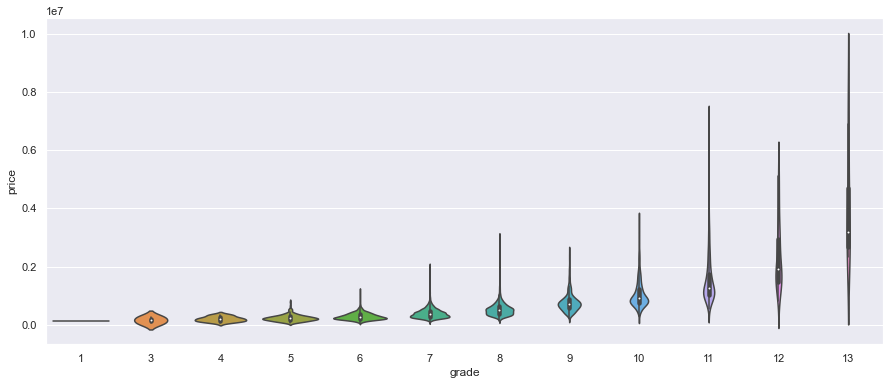

In [576]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=df, x=df['grade'], y=df['price'], ax=ax);

#### sqft_above
- The square footage of the interior housing space that is above ground level

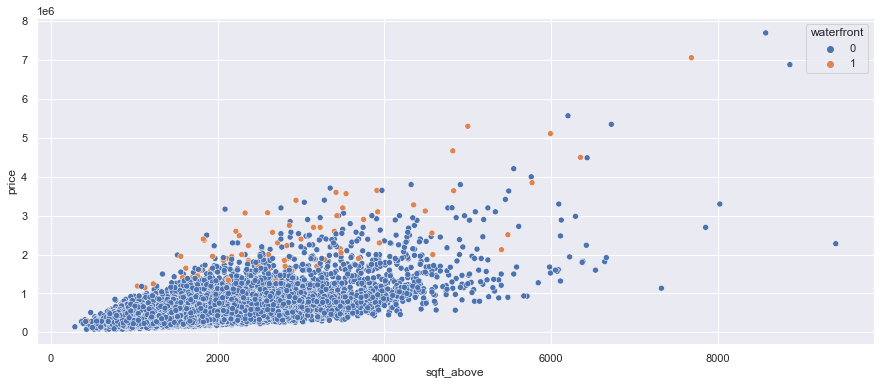

In [586]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_above, y=df.price, hue='waterfront', ax=ax);

#### sqft_basement
- The square footage of the interior housing space that is below ground level
- Below, we can see many properties don't have a basement listed, which could be for the following reasons:
  - could be that this data wasn't recorded for some where it's listed 0
  - could be that they are apartment complexes and in fact don't have a basement that's private to the individual resident
  - could be that they don't have a basement

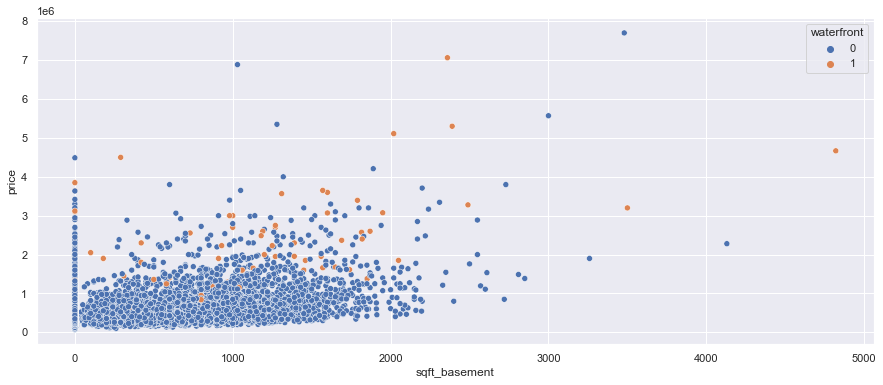

In [587]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_basement, y=df.price, hue='waterfront', ax=ax);

#### It might be useful to isolate only properties that have non-zero values for sqft_basement.

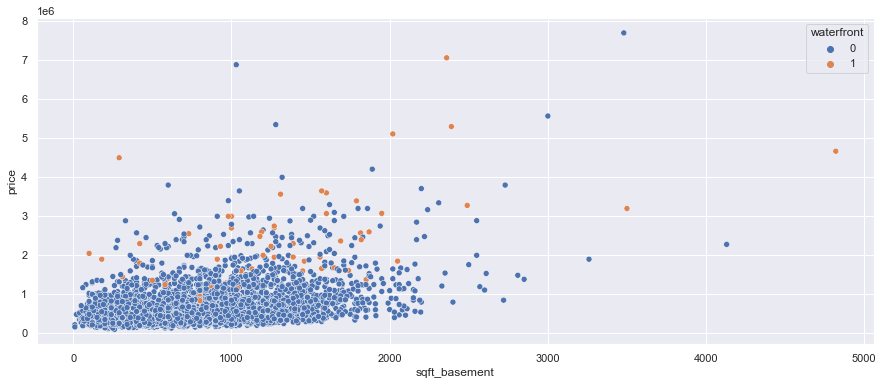

In [663]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df[df.sqft_basement != 0].sqft_basement, y=df.price, hue='waterfront', ax=ax);

#### yr_built
- The year the house was initially built
- initial takeaways: Nothing that spectacular here. Primary utility will be in what features may be engineered with this column.
  - one concern is that, in certain instances, **yr_built** is later than the sale year.
    - it is of course possible that certain buyers puchased the property before construction was finished.
    - Issues that could arrise:
      - for **yrs_since_ren_at_sale**, I will have to be careful with values that may be set negative because of this.

In [593]:
df.yr_built.describe()

count    17290.000000
mean      1970.792019
std         29.343516
min       1900.000000
25%       1951.000000
50%       1974.000000
75%       1996.000000
max       2015.000000
Name: yr_built, dtype: float64

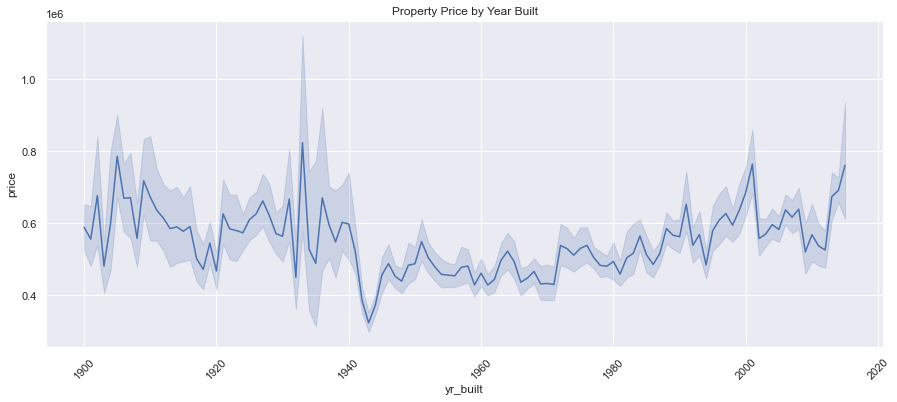

In [595]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Year Built')
plt.xticks(rotation=45)
sns.lineplot(data=df, x=df.yr_built, y=df.price, ax=ax);

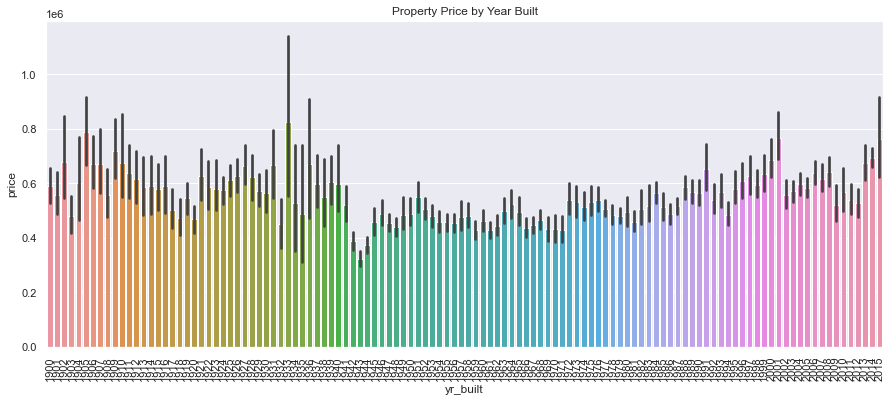

In [596]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Year Built')
plt.xticks(rotation=90)
sns.barplot(data=df, x=df.yr_built, y=df.price, ax=ax);

#### yr_renovated
- The year of the house’s last renovation
- having trouble manipulating this one appropriately, but I think engineered feature **'yrs_since_ren_at_sale'** will be better for insights.

In [598]:
df[df.yr_renovated == 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.000000,176.328502
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.000000,298.275862
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.000000,275.331565
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.000000,326.754386
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.000000,278.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2015-03-03,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,6,63,63,57,6720.000000,231.481481
17286,2014-05-20,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,6,73,73,67,3350.000000,338.461538
17287,2014-05-14,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,6,68,68,62,8826.000000,295.238095
17288,2014-12-04,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,6,50,50,44,41919.333333,225.000000


In [606]:
df[df.yr_renovated > 1700].yr_renovated.value_counts()

2014    71
2007    32
2005    32
2000    31
2013    30
        ..
1951     1
1948     1
1959     1
1944     1
1934     1
Name: yr_renovated, Length: 68, dtype: int64

In [608]:
df[df.yr_renovated == 0].yr_renovated.value_counts()

0    16564
Name: yr_renovated, dtype: int64

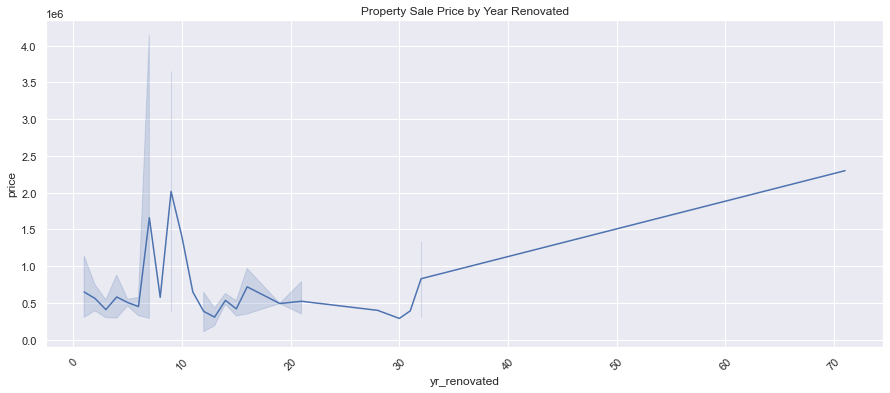

In [607]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price by Year Renovated')
plt.xticks(rotation=45)

sns.lineplot(data=df[df.yr_renovated > 1700], 
             x=df[df.yr_renovated > 1700].yr_renovated.value_counts(), 
             y=df.price, ax=ax);

#### zipcode
- What zipcode area the house is in
- **CATEGORICAL**
- Create dummy variables

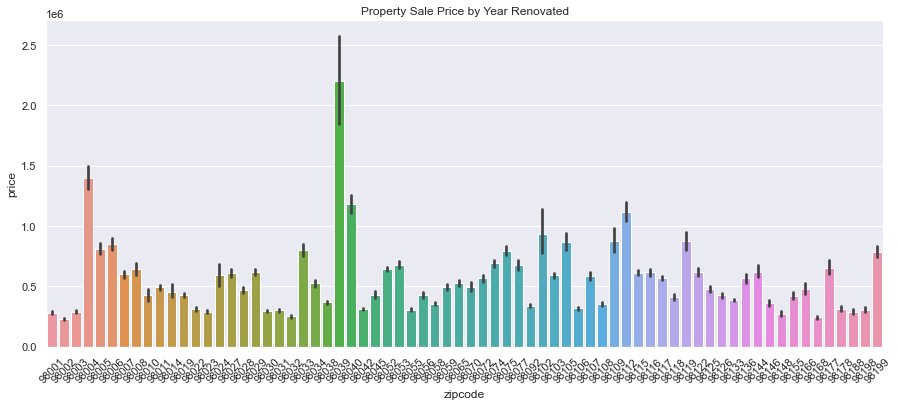

In [609]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price Comparisons by Zipcode')
plt.xticks(rotation=45)

sns.barplot(x='zipcode', y='price', data=df);

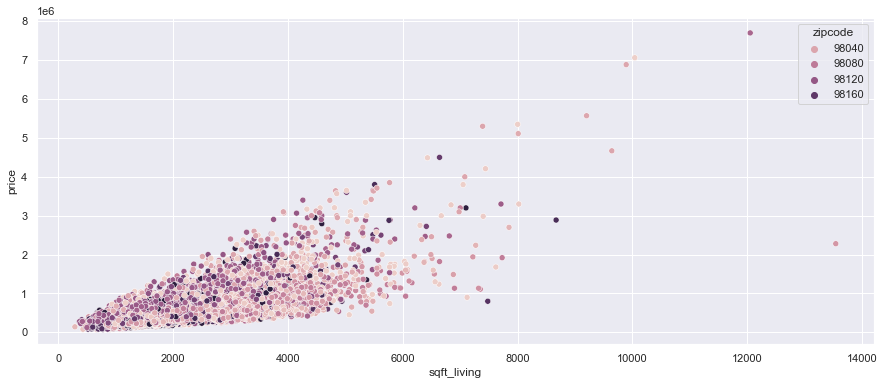

In [616]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_living, y=df.price, hue='zipcode', ax=ax);

In [247]:
df.zipcode.value_counts() # 70 different zipcodes... this is gonna be a wide-ass df

98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: zipcode, Length: 70, dtype: int64

In [612]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(zipcode_dummy_df.corr())

                          price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                  1.000000  0.313775   0.524335     0.703540  0.086803   
bedrooms               0.313775  1.000000   0.524033     0.588536  0.030674   
bathrooms              0.524335  0.524033   1.000000     0.755270  0.085470   
sqft_living            0.703540  0.588536   0.755270     1.000000  0.166810   
sqft_lot               0.086803  0.030674   0.085470     0.166810  1.000000   
floors                 0.256985  0.179908   0.497967     0.357169 -0.002205   
waterfront             0.275779 -0.008668   0.065848     0.109738  0.015356   
view                   0.395485  0.082724   0.188817     0.283336  0.073058   
condition              0.036099  0.021376  -0.122976    -0.061530 -0.013715   
grade                  0.666215  0.366405   0.664191     0.762929  0.110320   
sqft_above             0.607760  0.488420   0.686853     0.876696  0.180755   
sqft_basement          0.323312  0.307873   0.282700

AttributeError: 'NoneType' object has no attribute 'max'

In [611]:
df['price'].corr(df.zipcode)

-0.0489584854338204

In [339]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price_per_sqft_living'].median())

zipcode
98001    147.848438
98002    147.701149
98003    152.068841
98004    458.598726
98005    315.839361
98006    289.145907
98007    293.300881
98008    292.540569
98010    191.611074
98011    220.077220
98014    214.102564
98019    194.545455
98022    163.809524
98023    145.601586
98024    243.463035
98027    250.107759
98028    222.634508
98029    271.315789
98030    151.658768
98031    154.891304
98032    149.193548
98033    321.739130
98034    256.410788
98038    170.068027
98039    565.165614
98040    376.315789
98042    159.269912
98045    210.668563
98052    273.493721
98053    269.310828
98055    173.759710
98056    204.314641
98058    174.380165
98059    196.132597
98065    207.528958
98070    255.747126
98072    241.836735
98074    256.758607
98075    252.458803
98077    240.067646
98092    150.075758
98102    401.330614
98103    361.861862
98105    386.291949
98106    216.441441
98107    372.837617
98108    209.150327
98109    417.355372
98112    424.745797
98115    334

In [316]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price'].median())

zipcode
98001     261000.0
98002     229950.0
98003     265000.0
98004    1208000.0
98005     761225.0
98006     753000.0
98007     542250.0
98008     550000.0
98010     362500.0
98011     470000.0
98014     410500.0
98019     406250.0
98022     279000.0
98023     268250.0
98024     475000.0
98027     560000.0
98028     448500.0
98029     587500.0
98030     283200.0
98031     289950.0
98032     248000.0
98033     675000.0
98034     447450.0
98038     342000.0
98039    1892500.0
98040     989900.0
98042     292500.0
98045     390000.0
98052     615000.0
98053     634900.0
98055     296725.0
98056     380000.0
98058     332000.0
98059     430000.0
98065     499900.0
98070     467500.0
98072     505000.0
98074     645000.0
98075     737444.0
98077     652475.0
98092     312750.0
98102     745000.0
98103     560000.0
98105     679500.0
98106     312000.0
98107     529975.0
98108     346500.0
98109     736000.0
98112     940000.0
98115     561500.0
98116     568000.0
98117     535610.0
9811

In [340]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price'].std())

zipcode
98001    9.940111e+04
98002    5.332875e+04
98003    1.072202e+05
98004    7.980053e+05
98005    2.727417e+05
98006    4.474201e+05
98007    1.862670e+05
98008    3.832813e+05
98010    2.040606e+05
98011    1.280995e+05
98014    2.723450e+05
98019    1.259290e+05
98022    1.129660e+05
98023    1.136739e+05
98024    3.680076e+05
98027    2.848574e+05
98028    1.598076e+05
98029    1.932705e+05
98030    7.370928e+04
98031    7.392874e+04
98032    6.470881e+04
98033    4.748570e+05
98034    3.279277e+05
98038    1.389843e+05
98039    1.242894e+06
98040    6.179093e+05
98042    1.025196e+05
98045    1.910496e+05
98052    1.910254e+05
98053    2.682728e+05
98055    9.159672e+04
98056    2.392405e+05
98058    1.328835e+05
98059    2.352255e+05
98065    1.934769e+05
98070    1.988705e+05
98072    2.145114e+05
98074    2.784124e+05
98075    2.999751e+05
98077    2.663579e+05
98092    1.266444e+05
98102    8.723511e+05
98103    2.037417e+05
98105    4.823200e+05
98106    9.949839e+04
98

<AxesSubplot:title={'center':'Property Sale Price Comparisons by Zipcode'}>

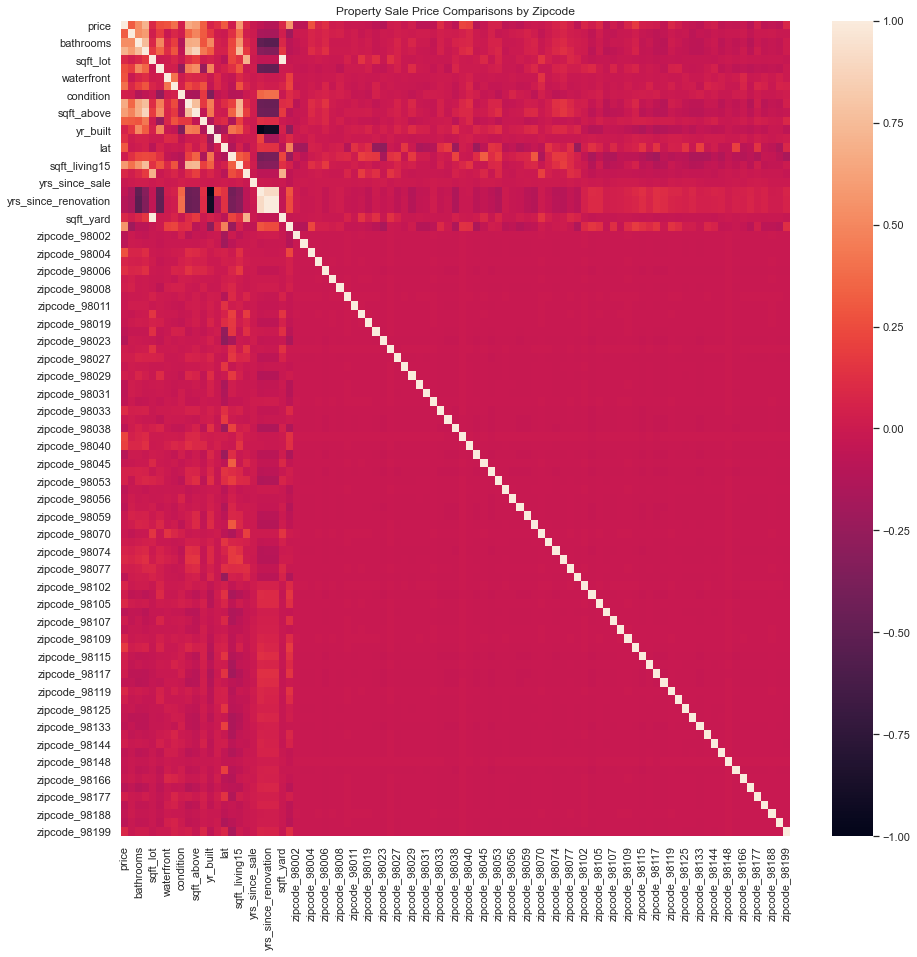

In [614]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Property Sale Price Comparisons by Zipcode')

sns.heatmap(zipcode_dummy_df.corr());

#### lat
- Lattitude

#### long
- Longitude

#### sqft_living15
- The mean square footage of interior housing living space for the nearest 15 neighbors
- Note: I've also seen it described as sq. ft. living after renovation, but I don't think this is accurate.

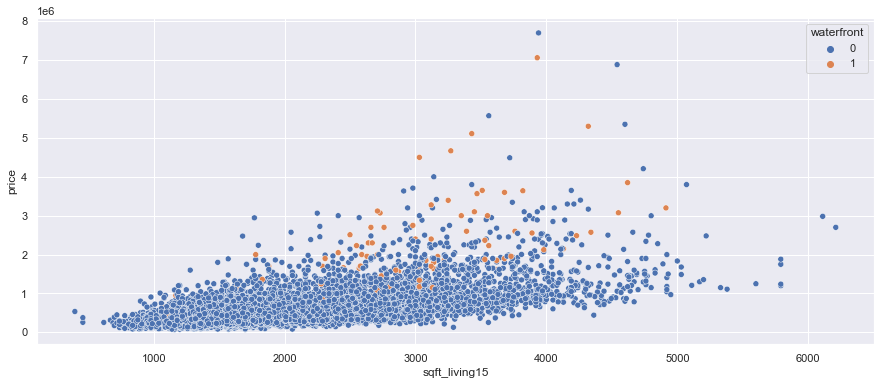

In [615]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_living15, y=df.price, hue='waterfront', ax=ax);

#### sqft_lot15
- The mean square footage of lot size for the nearest 15 neighbors

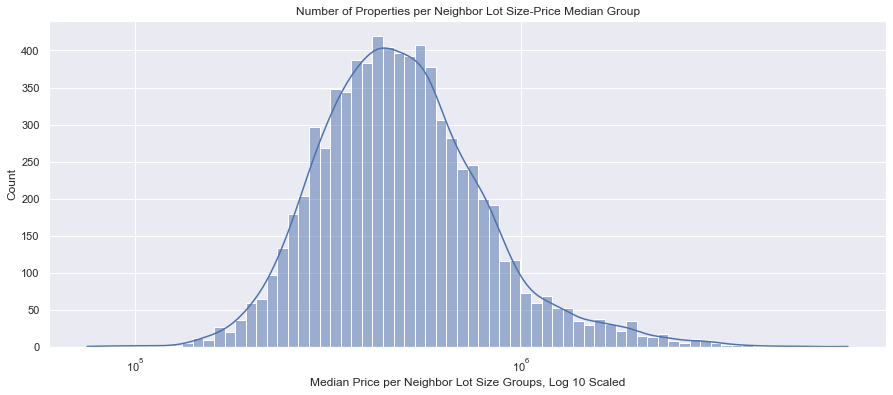

In [618]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Neighbor Lot Size Groups, Log 10 Scaled')
ax.set_title('Number of Properties per Neighbor Lot Size-Price Median Group')
sns.histplot(data=df, x=df.groupby('sqft_lot15')['price'].median(), kde=True, log_scale=10, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot15'], kde=True, log_scale=10, ax=ax);

Definitions verified from 2 sources:  
https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices  
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.htm

#### yrs_since_sale

#### yrs_old

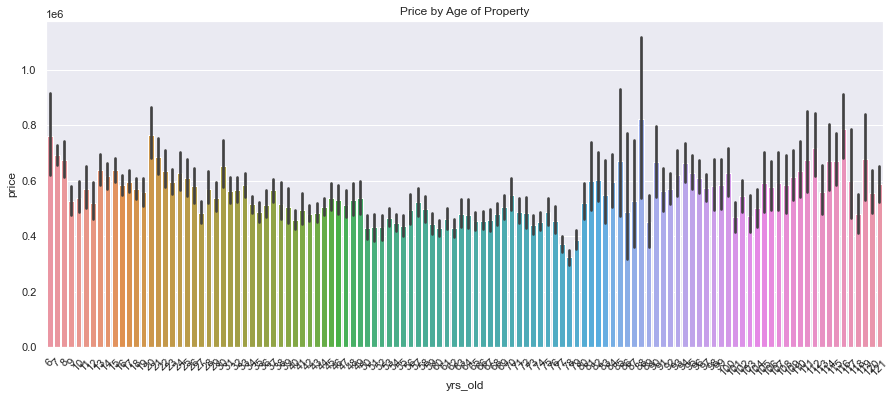

In [620]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Age of Property')
plt.xticks(rotation=45)
sns.barplot(data=df, x=df.yrs_old, y=df.price, ax=ax);

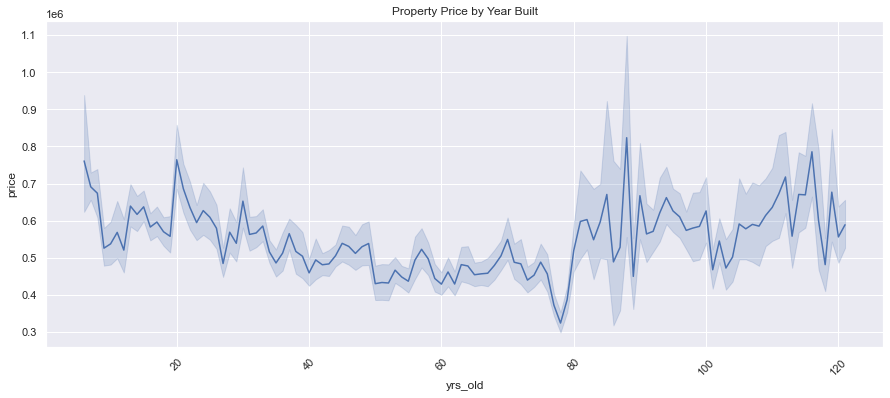

In [619]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Age of Property')
plt.xticks(rotation=45)
sns.lineplot(data=df, x=df.yrs_old, y=df.price, ax=ax);

#### yrs_since_renovation

#### yrs_since_ren_at_sale
- grrrr I was expecting this to be more interesting.

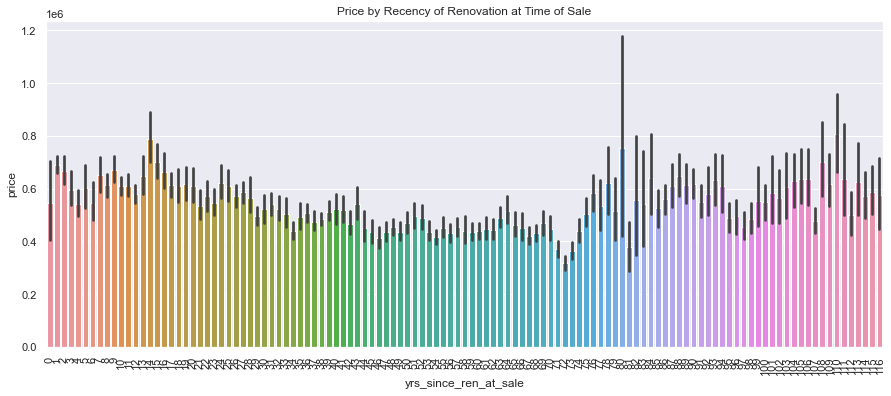

In [622]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Recency of Renovation at Time of Sale')
ax.set_xlabel('Number of Years Since Restored')
plt.xticks(rotation=90)
sns.barplot(data=df, x=df.yrs_since_ren_at_sale, y=df.price, ax=ax);

ValueError: cannot copy sequence with size 4986 to array axis with dimension 26

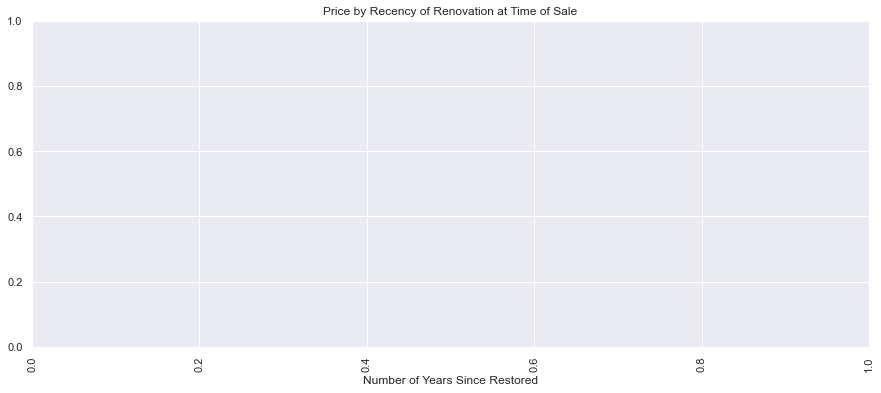

In [624]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Recency of Renovation at Time of Sale')
ax.set_xlabel('Number of Years Since Restored')
plt.xticks(rotation=90)
sns.barplot( 
            x=[df[df.yrs_since_ren_at_sale < 21], 
            df[(df.yrs_since_ren_at_sale > 20) & (df.yrs_since_ren_at_sale < 41)], 
            df[(df.yrs_since_ren_at_sale > 40) & (df.yrs_since_ren_at_sale < 61)],
            df[(df.yrs_since_ren_at_sale > 60) & (df.yrs_since_ren_at_sale < 81)],
            df[(df.yrs_since_ren_at_sale > 80) & (df.yrs_since_ren_at_sale < 101)],
            df[(df.yrs_since_ren_at_sale > 100)]],
            y=df.price, ax=ax);

#### sqft_yard

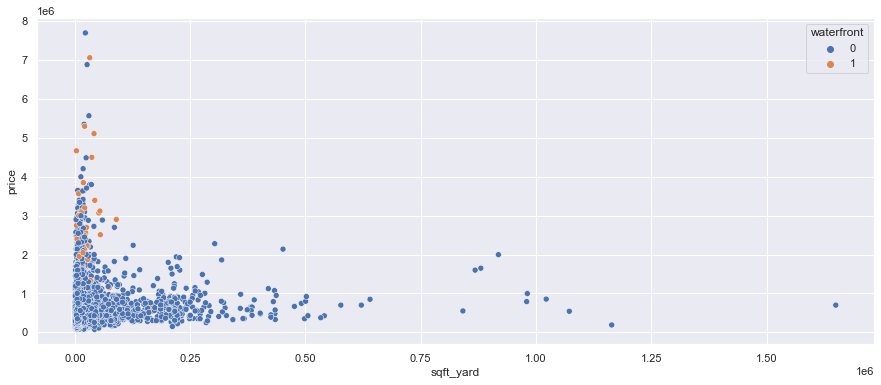

In [625]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_yard, y=df.price, hue='waterfront', ax=ax);

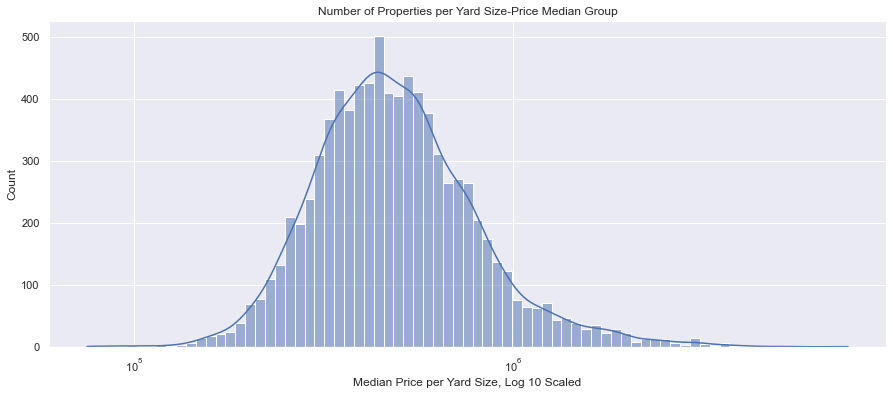

In [628]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Yard Size, Log 10 Scaled')
ax.set_title('Number of Properties per Yard Size-Price Median Group')
sns.histplot(data=df, x=df.groupby('sqft_lot')['price'].median(), kde=True, log_scale=10, ax=ax);

#### price_per_sqft_living

#### NOTE: We will NOT have price in holdout dataset, so do NOT use this feature for MODEL

Skew with histogram. Compensate with log scaling.

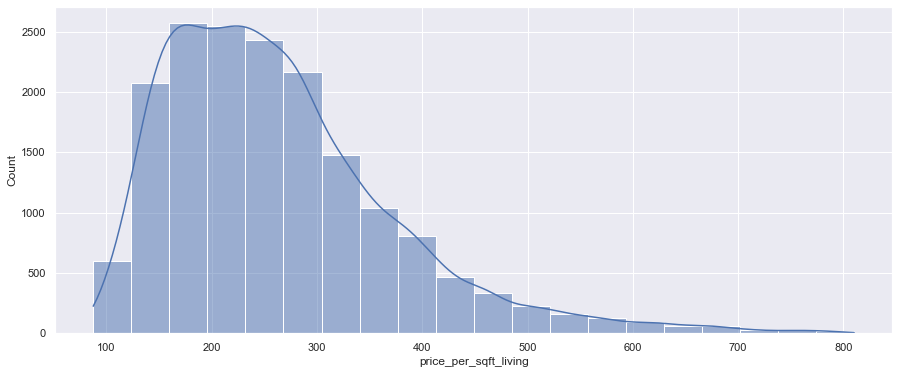

In [562]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(df.price_per_sqft_living, 
             bins=20,
             kde=True,
             ax=ax);

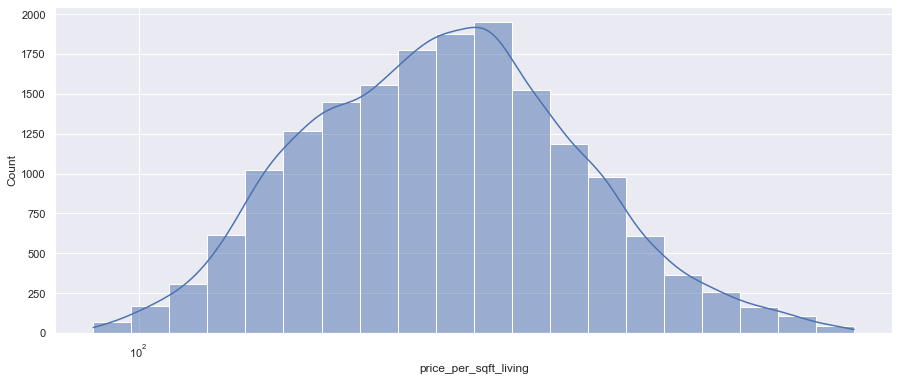

In [565]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(df.price_per_sqft_living, 
             bins=20,
             kde=True,
             log_scale=10,
             ax=ax);

In [310]:
mlr_model = ols(df.price_per_sqft_living, zip_df).fit()
mlr_model.summary()

PatsyError: model is missing required outcome variables

In [424]:
house_preds = df.drop('price', axis=1)
house_target = df['price']

In [423]:
ols().fit().summary()

TypeError: from_formula() missing 1 required positional argument: 'formula'

## Feature Engineering
- yrs_since_sale **ADDED**
- years_old **ADDED**
- yrs_since_renovation **ADDED**
- yrs_since_ren_at_sale **ADDED**
- sqft_yard **ADDED**
- price_per_sqft_living **ADDED** **Note: Not for use in model**
- sale_year **ADDED**
- sale_month **ADDED**
- sale_season
  - **ADDED** as dummy variable columns:
    - **sale_season_winter** 
    - **sale_season_spring** 
    - **sale_season_summer** 
    - **sale_season_fall**
  - Spring is hottest market for real estate
  - **do as dummy variable categories**
    - winter = Jan-Feb-March
    - spring = Apr-May-Jun
    - summer = July-Aug-Sept
    - fall = Oct-Nov-Dec
- inflation adjuster
  - note: not necessary if holdout dataset is from same years. 
  - this would be a feature cool for a bigger project.
- Geofencing
  - Seattle City Limits Fence LAT|LONG:
    - NE Corner:
      - 47.734178 -122.251569
    - SE Corner:
      - 47.495479 -122.251569
    - SW Corner:
      - 47.495479 -122.438230
    - NW Corner:
      - 47.734178 -122.438230
  - Rural Fence:
    - North Fence Post:
      - 47.777204 -121.961527
    - South Fence Post:
      - 47.078583 -121.961527
  - Would be useful to pinpoint locations that are near certain locations. Such as:
    - schools
    - universities
    - parks
    - beaches
    - lakes
    - general waterfront, if 'waterfront' column proves to be too dirty
    - museums
    - highways (or other nuisant noise polluters)
    - methadone clinics
    - homeless shelters
    - within city limits or more rural (appears to be divided by north-to-south routes 203-202-18-169-410) 
    - islands vs mainland
      - Vashon Island
      - Mercer Island
      - Maury Island
    - major employers
      - The Boeing Co. (71,829 employed statewide)
      - Amazon.com (60,000)
      - Microsoft Corp. (55,063)
      - Joint Base Lewis-McChord (54,000)
      - University of Washington Seattle (46,824)
      - source https://www.bizjournals.com/seattle/subscriber-only/2020/06/19/largest-employers.html
Geo_dist_index - to show how sales price is generally much higher when its within Seattle city limits and lower when its not, based off lattitude and longitude from just South of South Lake Union.

## Plotting Properties on Map

###  Properties within Seattle City Limits

In [637]:
within_seattle_df = df[df.within_seattle_city_limits ==1]

within_seattle_df_lat_list = within_seattle_df['lat'].tolist()
within_seattle_df_long_list = within_seattle_df['long'].tolist()

seattle_coords = []

mapit = None
for i in range(len(within_seattle_df_lat_list)):
    seattle_coords.append((within_seattle_df_lat_list[i], within_seattle_df_long_list[i]))

seattle_coords


[(47.6784, -122.285),
 (47.6599, -122.396),
 (47.6341, -122.361),
 (47.6052, -122.3),
 (47.5419, -122.289),
 (47.7074, -122.349),
 (47.7328, -122.288),
 (47.6179, -122.312),
 (47.5533, -122.363),
 (47.6382, -122.359),
 (47.7263, -122.363),
 (47.6103, -122.296),
 (47.6807, -122.318),
 (47.5704, -122.294),
 (47.6581, -122.39),
 (47.6501, -122.384),
 (47.6384, -122.343),
 (47.5313, -122.351),
 (47.7009, -122.317),
 (47.6567, -122.327),
 (47.635, -122.284),
 (47.6763, -122.267),
 (47.6103, -122.3),
 (47.5762, -122.415),
 (47.55, -122.272),
 (47.6403, -122.35),
 (47.6378, -122.301),
 (47.6032, -122.31),
 (47.6958, -122.357),
 (47.6256, -122.284),
 (47.6765, -122.32),
 (47.6896, -122.357),
 (47.5331, -122.278),
 (47.5114, -122.318),
 (47.6172, -122.298),
 (47.5789, -122.286),
 (47.6367, -122.364),
 (47.6462, -122.384),
 (47.5756, -122.316),
 (47.5675, -122.396),
 (47.6964, -122.336),
 (47.6925, -122.32),
 (47.6629, -122.325),
 (47.6994, -122.347),
 (47.5721, -122.309),
 (47.5323, -122.281),


In [639]:
seattle_coords[:5], seattle_coords[-5:]

([(47.6784, -122.285),
  (47.6599, -122.396),
  (47.6341, -122.361),
  (47.6052, -122.3),
  (47.5419, -122.289)],
 [(47.7164, -122.351),
  (47.7034, -122.297),
  (47.5929, -122.29),
  (47.5437, -122.388),
  (47.6687, -122.288)])

In [638]:
within_seattle_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,298.275862,0,1
7,2014-10-17,680000.0,3,2.50,1800,4400,1.0,0,0,5,7,1350,450,1970,0,98199,47.6599,-122.396,1920,4400,6,51,51,45,2600.0,377.777778,0,1
9,2014-05-16,605000.0,2,1.00,910,3600,1.0,0,0,4,7,910,0,1909,0,98119,47.6341,-122.361,1720,3600,6,112,112,106,2690.0,664.835165,0,1
10,2015-04-22,638000.0,3,1.00,1830,4400,1.5,0,0,4,8,1720,110,1930,0,98122,47.6052,-122.300,1650,4400,5,91,91,86,3180.0,348.633880,0,1
13,2015-05-07,365000.0,3,2.25,1960,1985,2.0,0,0,3,7,1750,210,2003,0,98118,47.5419,-122.289,1760,1985,5,18,18,13,1005.0,186.224490,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17273,2014-10-08,389000.0,3,1.00,1380,6591,1.0,0,0,4,7,1380,0,1947,0,98133,47.7164,-122.351,1610,6594,6,74,74,68,5211.0,281.884058,0,1
17280,2014-08-19,709050.0,4,3.50,2720,9000,2.0,0,0,3,8,2670,50,1997,0,98125,47.7034,-122.297,1960,7772,6,24,24,18,7640.0,260.680147,0,1
17281,2014-06-20,1462500.0,5,3.25,3840,4800,3.0,0,3,3,10,2750,1090,2008,0,98144,47.5929,-122.290,2060,4800,6,13,13,7,3520.0,380.859375,0,1
17282,2014-10-22,850000.0,4,3.25,3450,6500,2.0,0,0,3,8,2450,1000,1994,0,98136,47.5437,-122.388,1750,6500,6,27,27,21,4775.0,246.376812,0,1


In [ ]:
# WARNING: THIS SEEMS TO WORK BUT WILL BREAK BROWSER. ONLY USE FOR REFERENCE
# THIS WAS SUPPOSED TO MAP ALL PROPERTIES WITHIN SEATTLE CITY LIMITS 

# map = folium.Map(location = [47.6062, -122.3321], zoom_start = 4, tiles = "Mapbox bright")
# feature_group = folium.FeatureGroup('Properties Sold within Seattle')

# for coord in seattle_coords:
#     feature_group.add_child(folium.Marker(location=[47.6062, -122.3321]))

# map.add_child(feature_group)

In [ ]:
# Reference

folium.Marker(
    location=[40.7382584, -73.9549],
    radius=50,
    popup="DiJiFi",
    color="#1F77B4",
    fill=True,
    fill_color="#3186cc",
    tooltip = 'DiJiFi',
).add_to(mapit)
mapit

In [ ]:
df_lat_list = df['lat'].tolist()
df_long_list = df['long'].tolist()
king_county_coords = []
seattle_coords = []

within_seattle = df[df.within_seattle_city_limits ==1]

# np.where(df.within_seattle_city_limits == 1,
#                          seattle_coords.append)

for i in df:
    if df.within_seattle_city_limits == 1:
        seattle_coords.append((df_lat_list[i],ny_list_long[i]))

mapit = None
for i in range(len(df_lat_list)):
    king_county_coords.append((df_lat_list[i],ny_list_long[i]))
    


mapit = folium.Map(location=[40.7382584,-73.9549], tiles="Stamen Toner", zoom_start=14)
for coord in ny_coords:
    folium.Marker(location = [coord[0],coord[1]]).add_to(mapit)
# folium.Circle(
#     radius=100,
#     location=[40.7382584, -73.9549],
#     popup='DiJiFi',
#     color="crimson",
#     fill=False,
# ).add_to(mapit)


folium.CircleMarker(
    location=[40.7382584, -73.9549],
    radius=50,
    popup="DiJiFi",
    color="#1F77B4",
    fill=True,
    fill_color="#3186cc",
    tooltip = 'DiJiFi',
).add_to(mapit)
mapit

Seattle City Limits Fence LAT|LONG:  
NE Corner:  
47.734178 -122.251569 # must be LESS THAN lat LESS THAN long  
SE Corner:  
47.495479 -122.251569 # must be GREATER THAN lat LESS THAN long  
SW Corner:  
47.495479 -122.438230 # must be GREATER THAN lat GREATER THAN long  
NW Corner:  
47.734178 -122.438230 # must be LESS THAN lat GREATER THAN long  
  
-122.438230 < df.long < -122.251569  
47.495479 < df.lat < 47.734178  
  
df.long < -122.251569  
df.long > -122.438230  
df.lat < 47.734178  
df.lat > 47.495479  

In [44]:
df.price.isna().sum() # checking for null values in target

0

In [64]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [154]:
df_heat = df.loc[:, (df.columns != 'date') & (df.columns != 'id')]

In [155]:
df_heat

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,6
17286,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,6
17287,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,6
17288,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,6


<AxesSubplot:>

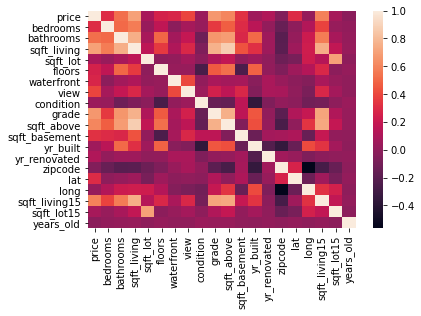

In [302]:
sns.heatmap(df_heat.corr())#, center=0)#, robust=True, ) # robust=True #annot = True to write data value in cell, center=0

highest correlated to price:
- sqft_living
- grade
- sqft_above
- sqft_living15

In [172]:
df.years_old.value_counts()

6    13770
5     3520
Name: date, dtype: int64

In [157]:
df.zipcode.value_counts()

98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: zipcode, Length: 70, dtype: int64

In [38]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [261]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard'],
      dtype='object')

In [41]:
df[df.bedrooms == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,3374500520,20150429,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,6306400140,20140612,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,1222029077,20141029,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,7849202190,20141223,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,2569500210,20141117,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,3918400017,20150205,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,1453602309,20140805,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,2954400190,20140624,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [ ]:
parse_dates : bool or list of int or names or list of lists or dict, default False
    The behavior is as follows:
        
         * boolean. If True -> try parsing the index.
    * list of int or names. e.g. If [1, 2, 3] -> try parsing columns 1, 2, 3
      each as a separate date column.
    * list of lists. e.g.  If [[1, 3]] -> combine columns 1 and 3 and parse as
      a single date column.
    * dict, e.g. {'foo' : [1, 3]} -> parse columns 1, 3 as date and call
      result 'foo'

    If a column or index cannot be represented as an array of datetimes,
    say because of an unparseable value or a mixture of timezones, the column
    or index will be returned unaltered as an object data type. For
    non-standard datetime parsing, use ``pd.to_datetime`` after
    ``pd.read_csv``. To parse an index or column with a mixture of timezones,
    specify ``date_parser`` to be a partially-applied
    :func:`pandas.to_datetime` with ``utc=True``. See
    :ref:`io.csv.mixed_timezones` for more.

    Note: A fast-path exists for iso8601-formatted dates.
infer_datetime_format : bool, default False
    If True and `parse_dates` is enabled, pandas will attempt to infer the
    format of the datetime strings in the columns, and if it can be inferred,
    switch to a faster method of parsing them. In some cases this can increase
    the parsing speed by 5-10x.
keep_date_col : bool, default False
    If True and `parse_dates` specifies combining multiple columns then
    keep the original columns.
date_parser : function, optional
    Function to use for converting a sequence of string columns to an array of
    datetime instances. The default uses ``dateutil.parser.parser`` to do the
    conversion. Pandas will try to call `date_parser` in three different ways,
    advancing to the next if an exception occurs: 1) Pass one or more arrays
    (as defined by `parse_dates`) as arguments; 2) concatenate (row-wise) the
    string values from the columns defined by `parse_dates` into a single array
    and pass that; and 3) call `date_parser` once for each row using one or
    more strings (corresponding to the columns defined by `parse_dates`) as
    arguments.

Cleaning that I'm not ready to toss:

In [ ]:
# df[df.yrs_since_ren_at_sale == 0]
# df[df.yr_renovated == 0]

In [657]:
# df['yrs_since_renovation'] = np.where(df.yrs_since_renovation == 2021, # cleans properties never renovated
#                                       df.yrs_old, 
#                                       df.yrs_since_renovation)

In [600]:
# df['yrs_since_renovation'] = np.where(df.yr_renovated == 0, # cleans properties never renovated
#                                       df.yrs_old, 
#                                       df.yr_renovated)